# ulmo SNOTEL Alaska example + MountainHub observations

2/25-20/2020. https://github.com/emiliom/

- Use `ulmo.cuahsi.wof.get_sites` function to ingest all SNOTEL sites, then clip to the specified bounding box (in Alaska).
- Explore adding additional site and variable information using `ulmo.cuahsi.wof.get_site_info` and `ulmo.cuahsi.wof.get_variable_info`
- Select one site and variable, then use `ulmo.cuahsi.wof.get_values` to obtain the corresponding time series, from start to end. Post-process the time series data, then plot it together with site and variable metadata
- Issue a request for MountainHub observations from the same bounding box
- Finally, plot both filtered (clipped) SNOTEL and MountainHub sites on an interactive Folium map, with clickable markers.

For additional code on how to read the time series data with `ulmo.cuahsi.wof.get_values`, see:
- This notebook focused on SNOTEL, but beware that it's 3 years old and some things may no longer work: https://github.com/uwescience/Python-for-geosciences/blob/master/20170307/ulmo-Snotel-cuahsiwof.ipynb
- This recent notebook, but for a different data source, not SNOTEL; see code starting at cell 14: https://nbviewer.jupyter.org/github/waterhackweek/tsdata_access/blob/master/Part2-ulmo_nwis_and_cuahsi.ipynb

In [1]:
%matplotlib inline

from collections import OrderedDict
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import geometry as sgeom
import folium

import ulmo
from ulmo.util import convert_datetime

import mtnhubsnow as mh

In [2]:
ulmo.__version__, gpd.__version__

('0.8.5', '0.7.0')

In [3]:
def sites_asgdf(ulmo_getsites, crs='epsg:4326'):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf

Note that some sites have this extra entry in the `get_sites` response:
```python
'site_property': {
    'county': 'Modoc',
    'state': 'California',
    'site_comments': 'beginDate=10/1/1983 12:00:00 AM|endDate=1/1/2100 12:00:00 AM|HUC=180200021403|HUD=18020002|TimeZone=-8.0|actonId=20H13S|shefId=ADMC1|stationTriplet=301:CA:SNTL|isActive=True',
    'pos_accuracy_m': '0'}
```

Enhance `sites_asgdf` to accommodate the optional `site_property` entry and its contents that may have a variable set of attribute (dict key) names.

## Set selection box as geodataframe

In [4]:
# Search Area -- a region in Alaska

# The dictionary keys adhere to the mtnhubsnow snow_data function requirement
box = {
    'latmax' : 75,
    'latmin' : 54,
    'lonmax': -140,
    'lonmin': -170,
}

# First convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(box['lonmin'], box['latmin'], box['lonmax'], box['latmax'])

In [5]:
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs='epsg:4326')

## Issue ulmo SNOTEL request

In [6]:
# WaterML/WOF WSDL endpoint url and Network Code
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"
networkcd = "SNOTEL"

In [7]:
sites = ulmo.cuahsi.wof.get_sites(wsdlurl)

In [8]:
type(sites), len(sites)

(dict, 931)

In [9]:
list(sites.keys())[:5]

['SNOTEL:301_CA_SNTL',
 'SNOTEL:907_UT_SNTL',
 'SNOTEL:916_MT_SNTL',
 'SNOTEL:1267_AK_SNTL',
 'SNOTEL:908_WA_SNTL']

In [10]:
sites[list(sites.keys())[0]]

{'code': '301_CA_SNTL',
 'name': 'Adin Mtn',
 'network': 'SNOTEL',
 'location': {'latitude': '41.2358283996582',
  'longitude': '-120.79192352294922'},
 'elevation_m': '1886.7120361328125',
 'site_property': {'county': 'Modoc',
  'state': 'California',
  'site_comments': 'beginDate=10/1/1983 12:00:00 AM|endDate=1/1/2100 12:00:00 AM|HUC=180200021403|HUD=18020002|TimeZone=-8.0|actonId=20H13S|shefId=ADMC1|stationTriplet=301:CA:SNTL|isActive=True',
  'pos_accuracy_m': '0'}}

## Convert sites to geodataframe, then clip to selection box

In [11]:
sites[list(sites.keys())[-1]]

{'code': '1033_CO_SNTL',
 'name': 'Zirkel',
 'network': 'SNOTEL',
 'location': {'latitude': '40.794879913330078',
  'longitude': '-106.59535217285156'},
 'elevation_m': '2846.83203125',
 'site_property': {'county': 'Jackson',
  'state': 'Colorado',
  'site_comments': 'beginDate=8/14/2002 6:00:00 AM|endDate=1/1/2100 12:00:00 AM|HUC=101800010202|HUD=10180001|TimeZone=-8.0|actonId=06J19S|shefId=ZIRC2|stationTriplet=1033:CO:SNTL|isActive=True',
  'pos_accuracy_m': '0'}}

In [12]:
sites_gdf = sites_asgdf(sites)

Use a GeoPandas spatial join (`sjoin`) to clip the `sites_gdf` geodataframe to the `box_gdf` polygonal geodataframe. `box_gdf` could be replaced by *any* polygonal geodataframe, not just a rectangular bounding box.

In [13]:
sites_box_gdf = gpd.sjoin(sites_gdf, box_gdf, how="inner")
sites_box_gdf.drop(columns='index_right', inplace=True)

In [14]:
len(sites_box_gdf)

61

In [15]:
sites_box_gdf.head()

,code,longitude,latitude,name,elevation_m,geometry
3,1267_AK_SNTL,-150.889664,61.749668,Alexander Lake,48.768001556396484,POINT (-150.88966 61.74967)
5,1189_AK_SNTL,-141.233765,64.789688,American Creek,320.04000854492188,POINT (-141.23376 64.78969)
6,1062_AK_SNTL,-151.315002,59.859718,Anchor River Divide,503.83441162109375,POINT (-151.31500 59.85972)
7,1070_AK_SNTL,-149.666824,61.114830,Anchorage Hillside,633.9840087890625,POINT (-149.66682 61.11483)
14,957_AK_SNTL,-149.478165,68.129829,Atigun Pass,1463.0400390625,POINT (-149.47816 68.12983)


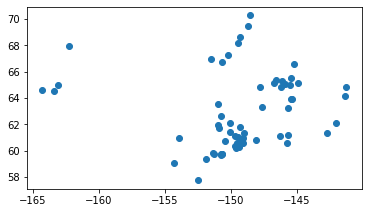

In [16]:
sites_box_gdf.plot();

## get_site_info
`get_site_info` will return the variables available at each site. That information will allow for a refinement to the selection, before issuing time series requests.

### Examine the first site in `sites_box_gdf`

In [17]:
sitecd = sites_box_gdf['code'].iloc[0]
sitecd

'1267_AK_SNTL'

In [18]:
siteinfo = ulmo.cuahsi.wof.get_site_info(wsdlurl, f"{networkcd}:{sitecd}")

In [19]:
siteinfo['network'], siteinfo['code'], siteinfo['name']

('SNOTEL', '1267_AK_SNTL', 'Alexander Lake')

In [20]:
siteinfo.keys()

dict_keys(['code', 'name', 'network', 'location', 'elevation_m', 'site_property', 'series'])

Each `series` is the time series for a variable.

In [21]:
siteinfo['series'].keys()

dict_keys(['SNOTEL:BATT_D', 'SNOTEL:BATT_H', 'SNOTEL:PRCP_y', 'SNOTEL:PRCP_sm', 'SNOTEL:PRCP_m', 'SNOTEL:PRCP_wy', 'SNOTEL:PRCPSA_y', 'SNOTEL:PRCPSA_D', 'SNOTEL:PRCPSA_sm', 'SNOTEL:PRCPSA_m', 'SNOTEL:PRCPSA_wy', 'SNOTEL:PREC_sm', 'SNOTEL:PREC_m', 'SNOTEL:SNWD_D', 'SNOTEL:SNWD_sm', 'SNOTEL:SNWD_H', 'SNOTEL:SNWD_m', 'SNOTEL:TAVG_y', 'SNOTEL:TAVG_D', 'SNOTEL:TAVG_sm', 'SNOTEL:TAVG_m', 'SNOTEL:TAVG_wy', 'SNOTEL:TMAX_y', 'SNOTEL:TMAX_D', 'SNOTEL:TMAX_sm', 'SNOTEL:TMAX_m', 'SNOTEL:TMAX_wy', 'SNOTEL:TMIN_y', 'SNOTEL:TMIN_D', 'SNOTEL:TMIN_sm', 'SNOTEL:TMIN_m', 'SNOTEL:TMIN_wy', 'SNOTEL:TOBS_D', 'SNOTEL:TOBS_sm', 'SNOTEL:TOBS_H', 'SNOTEL:TOBS_m', 'SNOTEL:WTEQ_D', 'SNOTEL:WTEQ_sm', 'SNOTEL:WTEQ_H', 'SNOTEL:WTEQ_m'])

In [22]:
list(siteinfo['series']['SNOTEL:WTEQ_D'].keys())

['variable',
 '{http://www.cuahsi.org/water_ml/1.1/}method',
 '{http://www.cuahsi.org/water_ml/1.1/}source',
 '{http://www.cuahsi.org/water_ml/1.1/}quality_control_level',
 '{http://www.cuahsi.org/water_ml/1.1/}variable_time_interval',
 '{http://www.cuahsi.org/water_ml/1.1/}value_count']

In [23]:
siteinfo['series']['SNOTEL:WTEQ_D']['variable']

{'value_type': 'Field Observation',
 'data_type': 'Continuous',
 'general_category': 'Soil',
 'sample_medium': 'Snow',
 'no_data_value': '-9999',
 'speciation': 'Not Applicable',
 'code': 'WTEQ_D',
 'id': '310',
 'name': 'Snow water equivalent',
 'vocabulary': 'SNOTEL',
 'time': {'is_regular': True,
  'interval': '1',
  'units': {'abbreviation': 'd',
   'code': '104',
   'name': 'day',
   'type': 'Time'}},
 'units': {'abbreviation': 'in',
  'code': '49',
  'name': 'international inch',
  'type': 'Length'}}

In [24]:
siteinfo['series']['SNOTEL:WTEQ_D']['{http://www.cuahsi.org/water_ml/1.1/}variable_time_interval']

{'variable_time_interval_type': 'TimeIntervalType',
 'begin_date_time': '2014-08-28T00:00:00',
 'end_date_time': '2020-03-02T00:00:00',
 'begin_date_time_utc': '2014-08-28T00:00:00',
 'end_date_time_utc': '2020-03-02T00:00:00'}

Issue `get_site_info` requests on all sites in `sites_box_gdf`. Create new gdf with only sites that have a specific variable `name` (not just variable `code`). Include `begin_date_time` and `end_date_time`

### Now query for `get_site_info` information from all sites in `sites_box_gdf` that have the variable SNOTEL:WTEQ_D
This can be slow if there are many sites!

In [25]:
varcd = 'SNOTEL:WTEQ_D'

In [46]:
siteinfo_variable_extract = []
for i,site in sites_box_gdf.iterrows():
    siteinfo = ulmo.cuahsi.wof.get_site_info(wsdlurl, f"{networkcd}:{site['code']}")
    # For now, select series based on the variable code, not the name (which spans multiple codes)
    if varcd in siteinfo['series']:
        series = siteinfo['series'][varcd]
        time_interval = series['{http://www.cuahsi.org/water_ml/1.1/}variable_time_interval']
        siteinfo_extract = (
            siteinfo['code'],
            int(series['{http://www.cuahsi.org/water_ml/1.1/}value_count']['value_count']),
            time_interval['begin_date_time'],
            time_interval['end_date_time'],
            series['variable']['no_data_value'],
            series['variable']['time']['units']['name']
        )
        siteinfo_variable_extract.append(siteinfo_extract)

In [47]:
len(siteinfo_variable_extract)

41

In [48]:
siteinfo_variable_extract

[('1267_AK_SNTL',
  2008,
  '2014-08-28T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('1189_AK_SNTL',
  3128,
  '2011-08-04T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('1062_AK_SNTL',
  14392,
  '1980-10-01T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('1070_AK_SNTL',
  5361,
  '2005-06-23T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('1182_AK_SNTL',
  11417,
  '1980-10-01T00:00:00',
  '2012-01-04T00:00:00',
  '-9999',
  'day'),
 ('1093_AK_SNTL',
  4226,
  '2008-08-01T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('958_AK_SNTL',
  9128,
  '1995-03-01T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('959_AK_SNTL',
  14027,
  '1981-10-01T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('1092_AK_SNTL',
  3158,
  '2011-07-05T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('1174_AK_SNTL',
  13662,
  '1982-10-01T00:00:00',
  '2020-03-02T00:00:00',
  '-9999',
  'day'),
 ('1268_AK_SNTL',
  135,
  '

### Select a site, then request the time series for the variable selected above

In [49]:
site_idx = 5

siteinfo_extract = siteinfo_variable_extract[site_idx]
sitecd = siteinfo_extract[0]
siteinfo_extract

('1093_AK_SNTL',
 4226,
 '2008-08-01T00:00:00',
 '2020-03-02T00:00:00',
 '-9999',
 'day')

In [50]:
site_tsval = ulmo.cuahsi.wof.get_values(wsdlurl, 
                                        f"{networkcd}:{siteinfo_extract[0]}",
                                        varcd,
                                        start=siteinfo_extract[2], 
                                        end=siteinfo_extract[3])

In [51]:
def site_series_values_to_df(series_values, variable_name, tzinfo=pytz.utc, nodata=None):
    """ Create a clean timeseries list of (dt,val) tuples
    """
    tsdt_tuplst = []
    for valdict in series_values['values']:
        value = float(valdict['value']) if float(valdict['value']) != float(nodata) else np.nan
        dt_tz = convert_datetime(valdict['datetime']).replace(tzinfo=tzinfo)
        tsdt_tuplst.append((dt_tz, value))

    
    dt, val = zip(*tsdt_tuplst)
    ts_df = pd.DataFrame({'time':dt, variable_name:val})
    ts_df.set_index('time', inplace=True)
    ts_df.sort_index(ascending=True, inplace=True)
    return ts_df

In [52]:
ts_df = site_series_values_to_df(site_tsval, varcd, 
                                 tzinfo=pytz.timezone('US/Pacific'),
                                 nodata=siteinfo_extract[-2])

In [53]:
ts_df.tail()

,SNOTEL:WTEQ_D
time,
2020-02-20 23:53:00-08:00,3.6
2020-02-21 23:53:00-08:00,3.6
2020-02-22 23:53:00-08:00,3.3
2020-02-23 23:53:00-08:00,3.2
2020-02-24 23:53:00-08:00,2.9


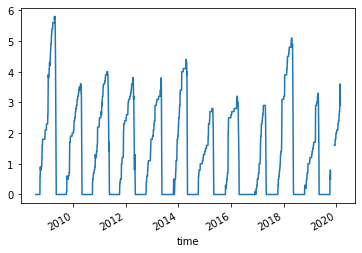

In [54]:
ts_df['SNOTEL:WTEQ_D'].plot();

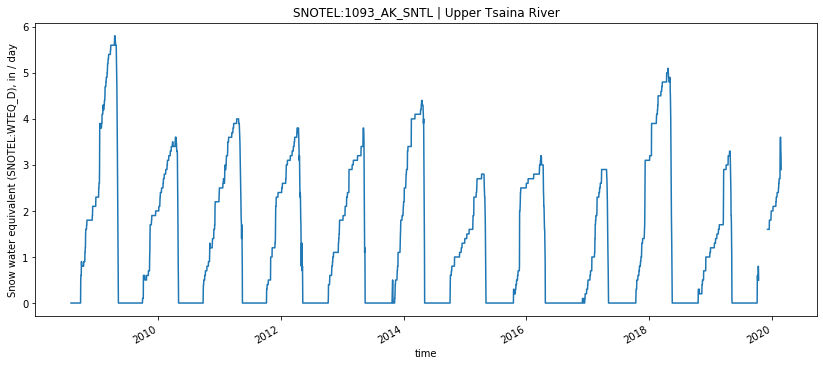

In [55]:
fig, ax = plt.subplots(figsize=(14, 6))
varlabel = ts_df.columns[0]
ts_df[varlabel].plot(style='-', ax=ax)

sitevariable = siteinfo['series'][varcd]['variable']
ax.set_ylabel(f"{sitevariable['name']} ({varlabel}), {sitevariable['units']['abbreviation']} / {siteinfo_extract[-1]}")
ax.set_title(f"{networkcd}:{sitecd} | {siteinfo['name']}");

## Get and parse information on all variables available from the SNOTEL service

In [56]:
variable_info = ulmo.cuahsi.wof.get_variable_info(wsdlurl)

In [57]:
len(variable_info.keys())

314

In [58]:
variable_info['SNOTEL:DPTP_H']

{'value_type': 'Field Observation',
 'data_type': 'Continuous',
 'general_category': 'Soil',
 'sample_medium': 'Air',
 'no_data_value': '-9999',
 'speciation': 'Not Applicable',
 'code': 'DPTP_H',
 'id': '7',
 'name': 'Temperature, dew point',
 'vocabulary': 'SNOTEL',
 'time': {'is_regular': True,
  'interval': '1',
  'units': {'abbreviation': 'hr',
   'code': '103',
   'name': 'hour',
   'type': 'Time'}},
 'units': {'abbreviation': 'degF',
  'code': '97',
  'name': 'degree fahrenheit',
  'type': 'Temperature'}}

Iterate to find and print out all variables with 'name' = 'Snow water equivalent'. Extract variable codes and associate, useful information.

In [59]:
select_variables = [
    (v['code'], v['units']['name'], v['no_data_value'], v['time']['is_regular'], 
     v['time']['is_regular'], v['time']['interval'], v['time']['units']['name']) 
    for _,v in variable_info.items() 
    if v['name'] == 'Snow water equivalent'
]
select_variables

[('WTEQ_D', 'international inch', '-9999', True, True, '1', 'day'),
 ('WTEQ_H', 'international inch', '-9999', True, True, '1', 'hour'),
 ('WTEQ_m', 'international inch', '-9999', True, True, '1', 'month'),
 ('WTEQ_sm', 'international inch', '-9999', True, True, '0', 'month')]

## MountainHub observations

Sometimes the MountainHub request hangs, then fails. In those cases, it almost always works on the second try.

In [60]:
mh_obs = mh.snow_data(limit=10000000, start=datetime(2019,11,9), bbox=box)

In [61]:
mh_obs_gdf = gpd.GeoDataFrame(
    mh_obs, 
    geometry=gpd.points_from_xy(mh_obs['longitude'], mh_obs['latitude'])
)

## Plot SNOTEL sites and MountainHub obs on interactive Folium map

In [62]:
m = folium.Map(tiles='Stamen terrain')

Blue markers are SNOTEL sites, red markers are MountainHub observations.

In [63]:
# SNOTEL
for idx, row in sites_box_gdf.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                  icon=folium.Icon(color='blue'),
                  popup="<b>{0}</b></br>{1}</br>Elevation (m): {2}".format(
                      row['code'], row['name'], row['elevation_m'])
                 ).add_to(m)

# MountainHub
for idx, row in mh_obs_gdf.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], 
                  icon=folium.Icon(color='red'),
                  popup="<b>{0}: {1:.1f}</b></br>{2}. Observation type: {3}</b> {4}".format(
                      row['datetime_utc'], row['snow_depth'], 
                      row['author_name'], row['obs_type'], row['description'])
                 ).add_to(m)

Add the search area box

In [64]:
folium.GeoJson(
    box_gdf,
    name='Search Area'
).add_to(m);

# folium.LayerControl().add_to(m)

In [65]:
# Set the map extent (bounds) to the extent of the sites
m.fit_bounds(m.get_bounds())

m